In [1]:
import os
# print(os.getcwd())

import numpy as np
import pandas as pd; pd.set_option('display.max_columns', None)
import warnings
warnings.simplefilter(action="ignore")

from scipy.stats import spearmanr
from scipy import stats

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import utils

# Config
sns.set_context('notebook', font_scale=1.3)

## Functions

In [2]:
def plot_trajectory_hued(
    df,
    pat_id,
    pft = 'fvc',
    time_col="months_since_first_session",
    # group_column="is_proctored",
    ax=None,
):
    ### VARS
    figsize = (10, 5)
    colors = sns.color_palette("colorblind").as_hex()
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=figsize)
    
    # Primer scatter
    colors = {'fvc': colors[0], 'svc': colors[3]}
    vars   = {'fvc': 'fvcPercPred_2019', 'svc': 'vcPercPred'}
    #for pft in {'fvc','svc'}:
    
    # Proctored
    data_proc = df.query('subject_order == @pat_id and pftType == @pft and is_proctored == True')
    x1_plot = data_proc[time_col].values
    y1_plot = data_proc[vars[pft]].values
    ax.scatter(
            x1_plot,
            y1_plot,
            color=colors[pft],
            marker='o',
            linewidths =1,
            label='Proctored', #f'{pft.upper()} proc',
            s=55,
        )
    
    # Non proctored
    data_nonproc = df.query('subject_order == @pat_id and pftType == @pft and is_proctored == False')
    x2_plot = data_nonproc[time_col].values
    y2_plot = data_nonproc[vars[pft]].values
    ax.scatter(
            x2_plot,
            y2_plot,
            color=colors[pft],
            marker='o',
            linewidth=1,
            facecolors="none",
            label='Non-proctored',#f'{pft.upper()} non proc',
            s=55,
        )
    
    # Regressions
    # for pft in {'fvc','svc'}:
    data_all = df.query('subject_order == @pat_id and pftType == @pft')
    x1_fit = data_all[time_col].values
    y1_fit = data_all[vars[pft]].values
    
    #########################
    (y_pred, _, _, _, slope, _, intercept, _) = utils.fit_regression(x1_fit, y1_fit, output_all=True)
    #########################
    x1_fit = np.append(x1_fit, 0)
    y_pred = np.append(y_pred, intercept)

    # # Extend forward
    # x1_fit = np.append(x1_fit, 15)
    # y_pred = np.append(y_pred, 15 * slope + intercept)
    ax.plot(
            x1_fit,
            y_pred,
            color='black',
            linewidth=2,
            label=None,
        )
        
    ax.grid()
    
def plot_figure3_figsupp3(
    data: pd.DataFrame,
    pat_list: list,
    pft: str = 'fvc',
    time_col="days_since_first_session",
    **kwargs,
):
    # FIXED VARS
    figsize=(12, 5)
    fs = 14
    label_y={'fvcPercPred_2019': 'FVC % predicted', 'vcPercPred': 'SVC % predicted'}
    xlabel='Months since enrollment'
    df = data.copy()
    ################
    n_cols = 2
    n_rows = 4
    
    # Creating the shared subplots (occupying the left half)
    fig = plt.figure(figsize=figsize, layout='constrained')
    gs = GridSpec(n_cols, n_rows, figure=fig, width_ratios=[1.5,1.5,1,1])
    
    # Create the subplots dynamically
    axs = [
            fig.add_subplot(gs[0, 0]), 
            fig.add_subplot(gs[0, 1]),
            fig.add_subplot(gs[1, 0]), 
            fig.add_subplot(gs[1, 1])
        ]
    
    for i, pat in enumerate(pat_list):
        
        _ = plot_trajectory_hued(
            df,
            pat_id=pat,
            time_col=time_col,
            pft = pft,
            ax=axs[i])

        axs[i].set_xlim(0,16)
        axs[i].set_xticks([0,4,8,12,16])
        if i == 0 or i == 1:
            axs[i].set_xticklabels([])
            
        axs[i].set_ylim(0,150)
        axs[i].set_yticks([0,50,100,150])
        if i == 1 or i == 3:
            axs[i].set_yticklabels([])

        if i==1:
            axs[i].legend(loc='upper right')
            
        # add patient id
        pat = df[df['subject_order'] == pat]['subject_order'].values[0]
        axs[i].text(0.05, 0.05, pat, fontsize=fs, transform=axs[i].transAxes, ha='left', va='bottom')
    
    fig.text(.29, -.025, xlabel, ha='center', va='center', fontsize=20)
    fig.text(-.025, 0.5, 'FVC % predicted', ha='center', va='center', rotation='vertical', fontsize=20)
    
    #######################
    #VALIDATE
    single_ax = fig.add_subplot(gs[:, 2:]) 
        
    def rmse(group):
        return np.sqrt(np.mean((group['vcPercPred'] - group['y_pred_vcPercPred']) ** 2))
    rmse_by_subject = df.groupby(['subject_order', 'is_proctored']).apply(rmse).reset_index(name='RMSE')
    rmse_by_subject['is_proctored_str'] = ['Proctored' if x else 'Non-proctored' for x in rmse_by_subject['is_proctored'].values]
    
    col1 = 'is_proctored_str'
    col2 = 'RMSE'

    # aux = rmse_by_subject[['subject_order', col1, col2]].drop_duplicates()
    aux = rmse_by_subject[['subject_order', col1, col2]].copy()
    print(f"Total of subjets: {len(aux)/2}")
    
    # Conduct t-test
    try:
        group1 = aux[aux[col1] == 'Proctored'][col2]
        group2 = aux[aux[col1] == 'Non-proctored'][col2]
        t_stat, p_value = stats.ttest_rel(group1, group2, nan_policy='omit')
    except Exception as e:
        print(e)
    
    if pft == 'fvc':
        palette = sns.color_palette("colorblind").as_hex()[:2]
        # map palette to is_proctored_str
        # palette = dict(zip(aux[col1].unique()[::-1], palette))
    else:
        # svc
        palette = sns.color_palette("colorblind").as_hex()[3:5]
    # map palette to is_proctored_str
    palette = dict(zip(aux[col1].unique()[::-1], palette))
    print(palette)
    
    aux.sort_values(by=col1, ascending = False, inplace=True)
    sns.boxplot(ax=single_ax, 
                x=col1,
                y=col2,
                fliersize=0,
                data=aux,
                palette = {'Proctored': 'white', 'Non-proctored': 'white'},)# palette=["#d1d0de","#5d6e9e"])

    # Aplicar alpha a un boxplot específico
    for i, artist in enumerate(single_ax.artists):  # Iterar sobre los boxplots
        if i == 1:  # Cambiar alpha para el primer boxplot (ajustar según tu caso)
            artist.set_alpha(0.5)

    sns.swarmplot(ax=single_ax, 
                  x=col1, 
                  y=col2, 
                  data=aux,
                  palette ={'Proctored': palette['Proctored'], 'Non-proctored': 'white'},
                  edgecolor = palette['Proctored'],
                  size=6, 
                  linewidth=1.2,)# edgecolor='0.25')

    # Customize plot
    single_ax.set_xlabel(None)
    single_ax.tick_params(axis='x', labelsize=20)  
    single_ax.set_ylabel('RMSE FVC % predicted', fontsize=20)
    single_ax.tick_params(axis='y', labelsize=12)
    single_ax.set_yticks(range(0, 19, 4))
    single_ax.set_ylim(0, 18)
    single_ax.spines["top"].set_color("black")
    single_ax.spines["right"].set_color("black")
    single_ax.spines["bottom"].set_color("black")
    single_ax.spines["left"].set_color("black")

    # Print t-test result
    print(f"T-statistic: {t_stat}, P-value: {p_value}")
    print(f"N subjects: {aux.subject_order.nunique()}")
    
    #######################
    # Format 
    # letters with automatic positioning
    axs[0].text(0.00, 1.35, 'a', fontsize=30, transform=axs[0].transAxes, va='top', ha='left')
    single_ax.text(0.00, 1.15, 'b', fontsize=30, transform=single_ax.transAxes, va='top', ha='left')
    
    plt.show()
    
    return fig #rmse_by_subject # para debug

## Data

In [4]:
PATH = 'data'
FILE = 'data_fig3.csv'
df_data = pd.read_csv(os.path.join(PATH,FILE))
df_data = df_data.query('pftType=="svc"')

print(f'N subjects: {df_data.subject_order.nunique()}')
print(f"N proctored sessions: {df_data.query('is_proctored==True').session_id_hash.nunique()}")
print(f"N non-proctored sessions: {df_data.query('is_proctored==False').session_id_hash.nunique()}")
print(f"N sessions: {df_data.session_id_hash.nunique()}")
df_data.head(3)

N subjects: 23
N proctored sessions: 316
N non-proctored sessions: 190
N sessions: 506


,subject_order,session_id_hash,date_only,days_since_first_session,months_since_first_session,n_fvc_atleast_usable,pftType,fvcPercPred_2019,vcPercPred,is_proctored,slope_fvcPercPred_2019,intercept_fvcPercPred_2019,slope_vcPercPred,intercept_vcPercPred,y_pred_fvcPercPred_2019,y_pred_vcPercPred
0,pALS 31,d198f225e1ad61f6db090ff9a11697f4578bbab87f237e...,2023-03-08,29,0.966667,0,svc,NaN,92.0,True,NaN,NaN,-0.1587,93.664866,NaN,93.664866
1,pALS 31,fed0e8f99d12054066518cc1139315278e72c09d9a0b88...,2023-03-14,35,1.166667,0,svc,NaN,100.0,True,NaN,NaN,-0.1587,93.664866,NaN,92.712665
2,pALS 31,e5705d02b8cb67a9fa62407f28c35c2e95c755cc4a19ce...,2023-03-21,42,1.400000,0,svc,NaN,104.0,True,NaN,NaN,-0.1587,93.664866,NaN,91.601763


## Figure

Total of subjets: 23.0
{'Proctored': '#d55e00', 'Non-proctored': '#cc78bc'}
T-statistic: -0.11310935084244708, P-value: 0.9109696665613021
N subjects: 23


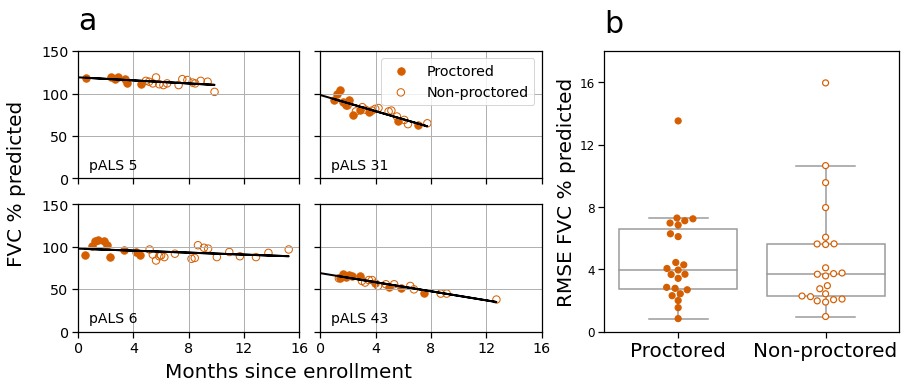

In [5]:
patient_sorted = [
    'pALS 5',#'b323b082-0ca4-4b58-b899-3e87e41074fb',
    'pALS 31',#'095b55de-6600-4d17-b8e6-387a7ef9db6f',
    'pALS 6',#'fc3f4670-6329-4886-868e-81eb8f8f7ba3',
    'pALS 43',#'9941063b-9b74-4eb0-b24f-b73cb9324ee5',
]

fig = plot_figure3_figsupp3(
    df_data, 
    patient_sorted,
    pft='svc',
    time_col="months_since_first_session",
)